In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import import_ipynb
import Captcha_seg
import time

importing Jupyter notebook from Captcha_seg.ipynb


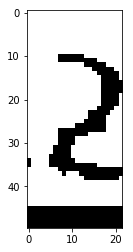

In [2]:
SEGMENTS_DIR = 'Segmented'
CAPTCHA_DIR = 'CAPTCHAs'
predictions = []
b_captcha = []

DATADIR = "./captcha_segmented/"
CATEGORIES= ["2","3","4","5","6","7","8","b","c","d","e","f","g","m","n","p","w","x","y"]
for category in CATEGORIES:
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
        plt.imshow(img_array, cmap="gray")
        break
    break

In [3]:
print(img_array.shape)

(50, 22)


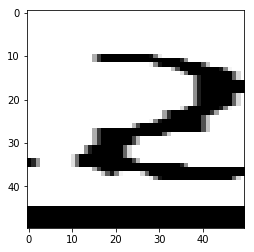

In [4]:
IMG_SIZE = 50

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap= 'gray')
plt.show()

In [5]:
train_data = []

def create_train_data():
    for category in CATEGORIES:
        path = os.path.join(DATADIR, category) 
        class_num = CATEGORIES.index(category)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
                train_data.append([new_array,class_num])
            except Exception as e:
                pass
            
create_train_data()

In [6]:
print(len(train_data))

3420


In [7]:
import random

random.shuffle(train_data)

In [8]:
for sample in train_data[:10]:
    print(sample[1])

13
1
2
10
6
14
2
12
1
14


In [9]:
X = []
y = []

In [10]:
for features, label in train_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

In [11]:
import pickle

pickle_out = open("X.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()
pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

In [12]:
pickle_in= open("X.pickle", "rb")
X = pickle.load(pickle_in)
X.shape[1:]

(50, 50, 1)

In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation, Flatten, Conv2D, MaxPooling2D

X = pickle.load(open("X.pickle","rb"))
y = pickle.load(open("y.pickle","rb"))

X = X/255.0

model = Sequential()

model.add(Conv2D(64,(3,3),input_shape= X.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))


model.add(Dense(19))
model.add(Activation("softmax"))

from keras.utils import to_categorical
y_binary = to_categorical(y)

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=['accuracy'])

model.fit(X,y_binary,batch_size=128, epochs=10, validation_split = 0.2)


Using TensorFlow backend.


Train on 2736 samples, validate on 684 samples
Epoch 1/10
2736/2736 [==============================] - 9s 3ms/step - loss: 2.8639 - acc: 0.1374 - val_loss: 2.5184 - val_acc: 0.3099
Epoch 2/10
2736/2736 [==============================] - 9s 3ms/step - loss: 1.7351 - acc: 0.5106 - val_loss: 1.3284 - val_acc: 0.6316
Epoch 3/10
2736/2736 [==============================] - 9s 3ms/step - loss: 0.9415 - acc: 0.7412 - val_loss: 1.0074 - val_acc: 0.7149
Epoch 4/10
2736/2736 [==============================] - 8s 3ms/step - loss: 0.6883 - acc: 0.8154 - val_loss: 0.7610 - val_acc: 0.7895
Epoch 5/10
2736/2736 [==============================] - 9s 3ms/step - loss: 0.5142 - acc: 0.8589 - val_loss: 0.6893 - val_acc: 0.8129
Epoch 6/10
2736/2736 [==============================] - 9s 3ms/step - loss: 0.4058 - acc: 0.8871 - val_loss: 0.5931 - val_acc: 0.8465
Epoch 7/10
2736/2736 [==============================] - 9s 3ms/step - loss: 0.3424 - acc: 0.9072 - val_loss: 0.5536 - val_acc: 0.8538
Epoch 8/10
2736

In [14]:
#model.summary()

In [15]:
def similarity(a,b):
    i =0
    for x,y in zip(a,b):
        if x==y:
            i+= 1
    percentage = (i/5) * 100
    return percentage

def prepare(filepath):
    IMG_SIZE = 50
    img_array = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    new_array = cv2.resize(img_array, (IMG_SIZE,IMG_SIZE))
    #plt.imshow(new_array,'gray')
    return new_array.reshape(-1, IMG_SIZE,IMG_SIZE,1)

total_time = 0
score = 0
count = 0
for captchas in os.listdir(CAPTCHA_DIR):
    start_time = time.time()
    predict_list= []
    captcha_name = captchas.split('.')
    print('\n')
    print('Actual: ',captcha_name[0])
    
    captcha_path =os.path.join(CAPTCHA_DIR,captchas)
    Captcha_seg.segment(captcha_path)
    
    files = []
    for segments in os.listdir(SEGMENTS_DIR):
        files.append(segments)
        files.sort()
    
    for segments in files:
        filepath = os.path.join(SEGMENTS_DIR,segments)
        prediction = model.predict([prepare(filepath)])
        predict_list.append(CATEGORIES[np.argmax(prediction[0])])
    
    elapsed_time = time.time()-start_time
    total_time += elapsed_time
    final_prediction = ''.join(predict_list)
    if captcha_name[0]== final_prediction:
        score +=1
    
    print('Predicted:',final_prediction,'\n')
    print('Percentage Similarity= ',similarity(captcha_name[0],final_prediction))
    print('Elapsed time= ',elapsed_time,'s')
    print('<------------------------------->')    
    predictions.append(similarity(captcha_name[0],final_prediction))
    count += 1


print('Total number of CAPTCHAS broken: ',score)    
print('Total number of CAPTCHAS attempted: ',count)
avg_prediction = score/count
print('Average Characters Predicted= ',avg_prediction,'%')
print('Total time taken= ',total_time,'s')
#model = tf.keras.models.load_model('captcha_alpha.model')
#prediction = model.predict([prepare('3.png')])
#print(len(prediction[0]))
#print(prediction[0])
#print(CATEGORIES[np.argmax(prediction[0])])



Actual:  ybfx6
Predicted: ybfxx 

Percentage Similarity=  80.0
Elapsed time=  0.051752567291259766 s
<------------------------------->


Actual:  nxc83
Predicted: dxce3 

Percentage Similarity=  60.0
Elapsed time=  0.012290000915527344 s
<------------------------------->


Actual:  p2m6n
Predicted: p2m6m 

Percentage Similarity=  80.0
Elapsed time=  0.012457847595214844 s
<------------------------------->


Actual:  ncyx8
Predicted: mcyx8 

Percentage Similarity=  80.0
Elapsed time=  0.0127410888671875 s
<------------------------------->


Actual:  gmmne
Predicted: gmmme 

Percentage Similarity=  80.0
Elapsed time=  0.012885570526123047 s
<------------------------------->


Actual:  md344
Predicted: md344 

Percentage Similarity=  100.0
Elapsed time=  0.011977434158325195 s
<------------------------------->


Actual:  y5dpp
Predicted: y5dpp 

Percentage Similarity=  100.0
Elapsed time=  0.012179851531982422 s
<------------------------------->


Actual:  x775w
Predicted: x775w 

Perce

Predicted: xmcym 

Percentage Similarity=  100.0
Elapsed time=  0.011612415313720703 s
<------------------------------->


Actual:  xf4p4
Predicted: xf4p4 

Percentage Similarity=  100.0
Elapsed time=  0.01442718505859375 s
<------------------------------->


Actual:  p4pde
Predicted: p4pde 

Percentage Similarity=  100.0
Elapsed time=  0.014431238174438477 s
<------------------------------->


Actual:  nwfde
Predicted: dwfde 

Percentage Similarity=  80.0
Elapsed time=  0.01180267333984375 s
<------------------------------->


Actual:  w46ep
Predicted: w46ep 

Percentage Similarity=  100.0
Elapsed time=  0.01250767707824707 s
<------------------------------->


Actual:  nnfx3
Predicted: nmfx3 

Percentage Similarity=  80.0
Elapsed time=  0.012024402618408203 s
<------------------------------->


Actual:  nny5e
Predicted: nmy5e 

Percentage Similarity=  80.0
Elapsed time=  0.011799097061157227 s
<------------------------------->


Actual:  pw5nc
Predicted: pwcnx 

Percentage Similarity

Predicted: n2e42 

Percentage Similarity=  40.0
Elapsed time=  0.012088537216186523 s
<------------------------------->


Actual:  nb45d
Predicted: fb45d 

Percentage Similarity=  80.0
Elapsed time=  0.011999130249023438 s
<------------------------------->


Actual:  nnp4e
Predicted: nmp4e 

Percentage Similarity=  80.0
Elapsed time=  0.013158559799194336 s
<------------------------------->


Actual:  neggn
Predicted: neggm 

Percentage Similarity=  80.0
Elapsed time=  0.011567354202270508 s
<------------------------------->


Actual:  n8ydd
Predicted: 28ycd 

Percentage Similarity=  60.0
Elapsed time=  0.010992050170898438 s
<------------------------------->


Actual:  pyf65
Predicted: pyf55 

Percentage Similarity=  80.0
Elapsed time=  0.010808229446411133 s
<------------------------------->


Actual:  fy2nd
Predicted: fy2nd 

Percentage Similarity=  100.0
Elapsed time=  0.01137232780456543 s
<------------------------------->


Actual:  gecmf
Predicted: gecmf 

Percentage Similarity=

Predicted: mpmy5 

Percentage Similarity=  100.0
Elapsed time=  0.011493444442749023 s
<------------------------------->


Actual:  ywn6f
Predicted: yyyn3 

Percentage Similarity=  20.0
Elapsed time=  0.011722087860107422 s
<------------------------------->


Actual:  g6n7x
Predicted: g6n7x 

Percentage Similarity=  100.0
Elapsed time=  0.013065338134765625 s
<------------------------------->


Actual:  w48cw
Predicted: wy43d 

Percentage Similarity=  20.0
Elapsed time=  0.014632701873779297 s
<------------------------------->


Actual:  m74dm
Predicted: n734m 

Percentage Similarity=  40.0
Elapsed time=  0.013381481170654297 s
<------------------------------->


Actual:  pgg3n
Predicted: pgg3n 

Percentage Similarity=  100.0
Elapsed time=  0.011524200439453125 s
<------------------------------->


Actual:  mmg2m
Predicted: mnxf3 

Percentage Similarity=  20.0
Elapsed time=  0.011052131652832031 s
<------------------------------->


Actual:  m22e3
Predicted: f72b7 

Percentage Similari

Predicted: nm4yy 

Percentage Similarity=  40.0
Elapsed time=  0.011813163757324219 s
<------------------------------->


Actual:  x458w
Predicted: x458w 

Percentage Similarity=  100.0
Elapsed time=  0.011921405792236328 s
<------------------------------->


Actual:  g55b4
Predicted: d55b4 

Percentage Similarity=  80.0
Elapsed time=  0.011435508728027344 s
<------------------------------->


Actual:  f7cey
Predicted: f7cyy 

Percentage Similarity=  80.0
Elapsed time=  0.01151418685913086 s
<------------------------------->


Actual:  w2n7e
Predicted: w2m7e 

Percentage Similarity=  80.0
Elapsed time=  0.011225223541259766 s
<------------------------------->


Actual:  px2xp
Predicted: px2xp 

Percentage Similarity=  100.0
Elapsed time=  0.011837959289550781 s
<------------------------------->


Actual:  p2x7x
Predicted: p2x7x 

Percentage Similarity=  100.0
Elapsed time=  0.011454105377197266 s
<------------------------------->


Actual:  ndme7
Predicted: fdme7 

Percentage Similarit

Predicted: f757f 

Percentage Similarity=  80.0
Elapsed time=  0.011794090270996094 s
<------------------------------->


Actual:  mgdwb
Predicted: mgdy3 

Percentage Similarity=  60.0
Elapsed time=  0.01398158073425293 s
<------------------------------->


Actual:  wbncw
Predicted: wnmxy 

Percentage Similarity=  20.0
Elapsed time=  0.011352300643920898 s
<------------------------------->


Actual:  gp7c5
Predicted: gp7c5 

Percentage Similarity=  100.0
Elapsed time=  0.011094808578491211 s
<------------------------------->


Actual:  mdyp7
Predicted: fdfgn 

Percentage Similarity=  20.0
Elapsed time=  0.012741804122924805 s
<------------------------------->


Actual:  gpxng
Predicted: gpxmg 

Percentage Similarity=  80.0
Elapsed time=  0.01199483871459961 s
<------------------------------->


Actual:  n336e
Predicted: n33ye 

Percentage Similarity=  80.0
Elapsed time=  0.011271953582763672 s
<------------------------------->


Actual:  pym7p
Predicted: pyyny 

Percentage Similarity= 

Predicted: f6ww3 

Percentage Similarity=  80.0
Elapsed time=  0.01180410385131836 s
<------------------------------->


Actual:  fcne6
Predicted: fcny3 

Percentage Similarity=  60.0
Elapsed time=  0.012117147445678711 s
<------------------------------->


Actual:  gc83b
Predicted: gc33b 

Percentage Similarity=  80.0
Elapsed time=  0.011613607406616211 s
<------------------------------->


Actual:  xymfn
Predicted: xymfn 

Percentage Similarity=  100.0
Elapsed time=  0.011670589447021484 s
<------------------------------->


Actual:  p24gn
Predicted: p24gn 

Percentage Similarity=  100.0
Elapsed time=  0.011081457138061523 s
<------------------------------->


Actual:  fp3wy
Predicted: fp3wy 

Percentage Similarity=  100.0
Elapsed time=  0.011656761169433594 s
<------------------------------->


Actual:  wyc25
Predicted: wy422 

Percentage Similarity=  60.0
Elapsed time=  0.01514291763305664 s
<------------------------------->


Actual:  nnf8b
Predicted: fnf8b 

Percentage Similarity